In [1]:
import pyaudio
import wave
import datetime
import os
import soundfile as sf
os.chdir("C:/Users/User/Documents/yamnet_short")

import csv, os, glob
import numpy as np
import tensorflow as tf
import features as features_lib
import tensorflow as tf
import yamnet_short

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

parent_dir = "C:/Users/User/Documents/cer_dataset_16k_flattened_resampled\\"
classes = os.listdir(parent_dir)
NUM_CLASSES=len(classes)
Yamnet_Short = yamnet_short.Yamnet_short(NUM_CLASSES)
yamnet_model = Yamnet_Short.model()
yamnet_model.load_weights("./training/20220411-122901/fold2/checkpoints/cp.ckpt")

import params as yamnet_params
def get_embedding(waveform):
  params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.25)
  waveform_padded = features_lib.pad_waveform(waveform, params)
  log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
      waveform_padded, params)
  return log_mel_spectrogram, tf.expand_dims(features, axis=-1)
# return log_mel_spectrogram

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 2
fs = 48000  # Record at 44100 samples per second
seconds = 0.5
p = pyaudio.PyAudio()  # Create an interface to PortAudio
p = pyaudio.PyAudio()
info = p.get_host_api_info_by_index(0)

numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

DEVICE_ID=1

import tensorflow_io as tfio
import tensorflow as tf
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

def get_waveform_no_label(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, dtype=tf.float32)
  # waveform = waveform/tf.reduce_max(waveform)
  return waveform


Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  External Microphone (Realtek(R)
Input Device id  2  -  Microphone Array (Realtek(R) Au


In [2]:
# parent_dirs = ["D:\\datasets\\audi\\driving_resampled_16k\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\**\\"]
parent_dir = "C:\\Users\\User\\Documents\\cer_dataset_16k_flattened_resampled\\"

classes = os.listdir(parent_dir)
NUM_CLASSES = len(classes)
filenames_all = []
for CLASS in classes:
    filenames_class=[]
    for layer in range(3): # look maximum 3 layers down
        path = os.path.join(parent_dir, CLASS, "**\\"*layer,"*.wav")
        filenames = glob.glob(os.path.join(parent_dir, CLASS, "**\\"*layer,"*.wav"))
        try:
            filenames_class.extend(filenames)
            # print(filenames_class)
        except: # if no files
            pass
    print("Number of files in {}: {}".format(CLASS, len(filenames_class)))    
    filenames_all.extend(filenames_class)
print("Number of files: ", len(filenames_all))

Number of files in Class_00_Modified_car_engines: 4644
Number of files in Class_01_Regular_Vehicles: 3873
Number of files in Class_02_Tires_and_Skidding: 1144
Number of files in Class_03_Tools_and_Mechanisms: 6049
Number of files in Class_04_Explosion: 1295
Number of files in Class_05_Environmental_Sounds: 6723
Number of files:  23728


In [3]:
import glob
import librosa
import matplotlib.pyplot as plt
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

top_n = 6

def plot_filename(filename):
    wav, sr = librosa.load(filename, sr=16000)
    waveform = tf.cast(wav, dtype=tf.float32)

    spec, melspec = get_embedding(waveform) 
    scores = np.array(yamnet_model.predict(melspec))
    
    plt.figure(figsize=(10, 6))

    # Plot the waveform.
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])

    # Plot the log-mel spectrogram (returned by the model).
    plt.subplot(3, 1, 2)
    plt.imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')

    # Plot and label the model output scores for the top-scoring classes.
    mean_scores = np.mean(scores, axis=0)
    # top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    top_class_indices=np.arange(6)
    plt.subplot(3, 1, 3)
    # plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    score_map = (scores[:, top_class_indices].T)
    max_score = np.argmax(score_map, axis=0)
    max_score_onehot = tf.one_hot(max_score,6).numpy().T
    # score_map_top1 = np.zeros(score_map.shape)
    plt.imshow(score_map)
    plt.imshow(max_score_onehot,alpha=0.6)

    # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    # values from the model documentation
    patch_padding = (0.96 / 2) / 0.25
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    # Label the top_N classes.
    yticks = range(0, top_n, 1)
    plt.yticks(yticks, [classes[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n, 0]))

FILENAME_ALL_LENGTH = len(filenames_all)

Predictions for each embedding: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3],     
Prediction Class name: Class_03_Tools_and_Mechanisms 
Real Class and file name: Class_03_Tools_and_Mechanisms\AudioSet_Tools\HDvDspBjy_w_40.wav


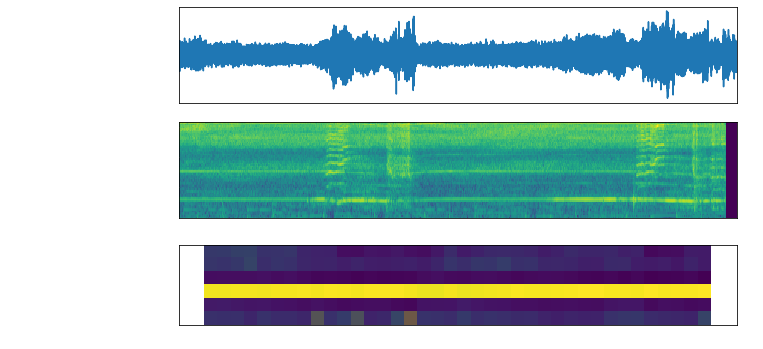

In [9]:
import random
import librosa
import scipy

filename = filenames_all[random.randint(0,FILENAME_ALL_LENGTH)]
type(filename)
wav, sr = librosa.load(filename, sr=16000)
spec, melspec = get_embedding(wav) 
scores = tf.argmax(yamnet_model.predict(melspec), axis=1)
most_scored = scipy.stats.mode(scores)
print("Predictions for each embedding: {}, \
    \nPrediction Class name: {} \nReal Class and file name: {}".format(
        scores, classes[most_scored.mode[0]], filename.split("resampled\\")[-1]
        ))
plot_filename(filename)

In [10]:
import glob
import librosa
import matplotlib.pyplot as plt
from tkinter import TclError
# to display in separate Tk window
%matplotlib tk

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# COLOR = 'white'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR

# filenames = glob.glob("C:/Users/User/Documents/yamnet_short/test_save_files/*.wav")

FILENAME = "./test_save_files/output"
top_n = 6

def get_time_delayed():
    now = datetime.datetime.now()
    timenow = now.strftime("%Y-%m-%d_%H-%M-%S")
    second = timenow.split('-')[-1]
    second = int(second)-1
    second = "%02d" % (second,)
    timenowdelayed = '-'.join(timenow.split('-')[:-1])
    timedelayed = timenowdelayed+'-'+second
    return timedelayed

try:
    # pass
    !del /S .\test_save_files\**"    
except:
    pass
first_loop_flag=True
now = datetime.datetime.now()
prev_now=now
# while 1==1:
for i in range(10000):
    # endTime = datetime.datetime.now() + datetime.timedelta(seconds=1)
    # while True:
    #     if datetime.datetime.now() >= endTime:
    #         break
    
    time_delayed = get_time_delayed()
    # filenames_all = glob.glob("./test_save_files/*.wav")
    # filename = filenames_all[i]
    filename = "{}_{}.wav".format(FILENAME, time_delayed)
    print("Processing file: {}".format(filename))
        
    try:
        wav, sr = librosa.load(filename, sr=16000)
        # wav = get_waveform_no_label(filename)
        os.system("del /S {}".format(filename))

        # waveform = tf.cast(wav, dtype=tf.float32)
        waveform=wav
        spec, melspec = get_embedding(waveform) 
        scores = np.array(yamnet_model.predict(melspec))
        
        if first_loop_flag==True:

            # fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
            fig, ax = plt.subplots(3, figsize=(10, 6))
            ax=ax.flatten()
            wave_plot, = ax[0].plot(waveform)
            ax[0].axis(xmin=0,xmax=len(waveform), ymin=-1, ymax=1) #xlim([0, len(waveform)])

            spec_plot = ax[1].imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
            score_map = (scores.T)
            max_score = np.argmax(score_map, axis=0)
            max_score_onehot = tf.one_hot(max_score,6).numpy().T
            # score_map_top1 = np.zeros(score_map.shape)
            # ax3.imshow(score_map)
            # ASPECT = score_map.shape[1]/score_map.shape[0]
            # score_map = scipy.special.softmax(score_map, axis=1)
            # score_plot = ax[2].imshow(score_map, extent=[0,score_map.shape[1],0,score_map.shape[0]], aspect=5)
            score_plot = ax[2].imshow(max_score_onehot)
            # ASPECT = int(score_map.shape[0]/score_map.shape[1])
            # score_plot = ax[2].imshow(
            #     score_map, extent=[0,score_map.shape[0],0,score_map.shape[1]], 
            #     aspect=ASPECT
            #     )
            # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
            # values from the model documentation
            # patch_padding = 0
            patch_padding = (0.96 / 2) / 0.25
            ax[2].axis(xmin=-patch_padding-0.5,xmax=score_map.shape[1] + patch_padding-0.5) # xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
            # Label the top_N classes.
            top_class_indices = np.arange(6)
            # yticks = np.arange(6,0,-1)-0.5
            yticks=np.arange(6)
            ax[2].set_yticks(yticks, classes)
            _ = ax[2].axis(ymax=-0.5, ymin=top_n-0.5) #.()ylim
            # _ = ax[2].axis(ymax=-0.5, ymin=-0.5 + top_n) #.()ylim
            first_loop_flag=False

        # Plot the waveform.
        wave_plot.set_ydata(waveform)
        # Plot the log-mel spectrogram (returned by the model).
        spec_plot.set_data(spec.numpy().T)
        # Plot and label the model output scores for the top-scoring classes.
        score_map = (scores.T)
        max_score = np.argmax(score_map, axis=0)
        max_score_onehot = tf.one_hot(max_score,6).numpy().T
        # score_map_top1 = np.zeros(score_map.shape)
        # plt.imshow(score_map)
        # score_plot.set_data(score_map)# ,alpha=0.6)
        score_plot.set_data(max_score_onehot)# ,alpha=0.6)
        # score_plot.set_xlabel("Most Recent Prediction: {}".format(classes[np.argmax(max_score_onehot[:,-1])]))
                # score_plot.set_alpha(0.6)
        # score_plot.set_data(max_score_onehot)# ,alpha=0.6)
        fig.canvas.draw()
        fig.canvas.flush_events()

    except:
        print("Error")

Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-32.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-33.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-34.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-35.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-36.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-37.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-38.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-39.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-40.wav
Deleted file - C:\Users\User\Documents\yamnet_short\test_save_files\output_2022-04-13_22-52-41.wav
Deleted fi

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58-00.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-58

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59--1.wav
Error
Processing file: ./test_save_files/output_2022-04-13_22-59-00.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-00.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-00.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-01.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-01.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-02.wav
Processing file: ./test_save_files/output_2022-04-13_22-59-02.wav
Processing file: ./test_save

'Class_03_Tools_and_Mechanisms'

In [ ]:
import scipy
scipy.special.softmax(scores, axis=1)

array([[0.1446832 , 0.16851284, 0.11857402, 0.25575775, 0.12980513,
        0.18266708],
       [0.13140641, 0.20569128, 0.11204232, 0.20202653, 0.12705359,
        0.22177997],
       [0.13116778, 0.1706874 , 0.11631979, 0.21426906, 0.18863752,
        0.1789186 ],
       [0.16424589, 0.15513097, 0.11791962, 0.21358708, 0.142699  ,
        0.20641756],
       [0.14543884, 0.18778664, 0.12783574, 0.22010314, 0.11277193,
        0.20606382],
       [0.1539547 , 0.23747106, 0.11284275, 0.21326756, 0.11601517,
        0.1664487 ],
       [0.14493382, 0.19427653, 0.11006434, 0.23797758, 0.11404245,
        0.19870524],
       [0.12480821, 0.19677675, 0.11930306, 0.2556727 , 0.13078761,
        0.17265166],
       [0.12039966, 0.17236544, 0.11734267, 0.24266097, 0.11584488,
        0.23138653],
       [0.12438248, 0.2055464 , 0.10672163, 0.22411524, 0.11202435,
        0.22720993],
       [0.1258949 , 0.23435882, 0.12890789, 0.22141829, 0.1155467 ,
        0.17387345],
       [0.12861373, 0

In [ ]:
import numpy as np
yticks = np.arange(6,0,-1)-0.5
yticks

array([5.5, 4.5, 3.5, 2.5, 1.5, 0.5])

In [ ]:
import numpy as np
top_class_indices = np.arange(6)
yticks = range(6)


In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
fig, ax = plt.subplots(3, figsize=(10, 6))
ax=ax.flatten()
wave_plot, = ax[0].plot(waveform)
ax[0].axis(xmin=0,xmax=len(waveform), ymin=-1, ymax=1) #xlim([0, len(waveform)])

spec_plot = ax[1].imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
score_map = (scores.T)
max_score = np.argmax(score_map, axis=0)
max_score_onehot = tf.one_hot(max_score,6).numpy().T
# score_map_top1 = np.zeros(score_map.shape)
# ax3.imshow(score_map)
score_plot = ax[2].imshow(score_map, aspect=int(score_map.shape[0]/score_map.shape[1]))
        # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.015 / 2) / 0.01
ax[2].axis(xmin=-patch_padding-0.5,xmax=scores.shape[0] + patch_padding-0.5) #xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
ax[2].set_yticks(np.arange(6), classes)
_ = ax[2].axis(ymax=-0.5, ymin=-0.5 + top_n) #.()ylim
first_loop_flag=False

In [ ]:
ASPECT = score_map.shape[1]/score_map.shape[0]
score_plot = ax[2].imshow(score_map, extent=[0,score_map.shape[1],0,score_map.shape[0]], aspect=5)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\tkinter\__init__.py", line 814, in callit
    func(*args)
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\matplotlib\backends\_backend_tk.py", line 251, in idle_draw
    self.draw()
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super().draw()
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\matplotlib\backends\backend_agg.py", line 436, in draw
    self.figure.draw(self.renderer)
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\matplotlib\artist.py", line 73, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\matplotlib\artist.py", line 50, in draw_wrapper
 

In [ ]:
# filenames_all = glob.glob("./test_save_files/*.wav")
# filename = filenames_all[0]
# # filename = "{}_{}.wav".format(FILENAME, time_delayed)
# wav, sr = librosa.load(filename, sr=16000)
# waveform = tf.cast(wav, dtype=tf.float32)
# spec, melspec = get_embedding(waveform) 
# scores = np.array(yamnet_model.predict(melspec))

# # fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
# fig, ax = plt.subplots(3, figsize=(10, 6))
# ax=ax.flatten()
# wave_plot, = ax[0].plot(waveform)
# ax[0].axis(xmin=0,xmax=len(waveform)) #xlim([0, len(waveform)])

# spec_plot = ax[1].imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
# score_map = (scores.T)
# max_score = np.argmax(score_map, axis=0)
# max_score_onehot = tf.one_hot(max_score,6).numpy().T
# # score_map_top1 = np.zeros(score_map.shape)
# # ax3.imshow(score_map)
# score_plot = ax[2].imshow(max_score_onehot,alpha=0.6)
#         # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# # values from the model documentation
# patch_padding = (0.025 / 2) / 0.01
# ax[2].axis(xmin=-patch_padding-0.5,xmax=scores.shape[0] + patch_padding-0.5) #xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# # Label the top_N classes.
# yticks = range(0, 6, 1)
# top_class_indices=np.arange(6)
# ax[2].set_yticks(yticks, [classes[top_class_indices[x]] for x in yticks])
# _ = ax[2].axis(ymin=-0.5, ymax=-0.5 + top_n) #.()ylim
# first_loop_flag=False